In [354]:
using Plots
using Plots.PlotMeasures
using StatsPlots
using StatsBase
using Roots
using Roots
using Base.Threads
using BenchmarkTools
using QuadGK
using JLD2
include("../../LogLoss/RealRealHighDimension.jl");

In [355]:
proba_density(state::Vector, rdm::Matrix) = abs(state' * rdm * state)
function proba_density(x::Float64, rdm::Matrix, encoding::Symbol, d::Int)
    enc = model_encoding(encoding)
    state = enc.encode(x, d)
    return abs(state' * rdm * state)
end

proba_density (generic function with 2 methods)

In [356]:
enc = model_encoding(:Legendre_No_Norm)
state = enc.encode(0.4, 12)
rdm = state * state'

12×12 Matrix{Float64}:
  0.5         0.34641    -0.290689   …  -0.411401    0.221886    0.588816
  0.34641     0.24       -0.201395      -0.285027    0.153727    0.407943
 -0.290689   -0.201395    0.169          0.239179   -0.129      -0.342324
 -0.582065   -0.403267    0.3384         0.478924   -0.258304   -0.685458
 -0.1695     -0.117433    0.0985435      0.139465   -0.0752194  -0.199608
  0.448806    0.310942   -0.260926   …  -0.369278    0.199168    0.528528
  0.527557    0.365502   -0.30671       -0.434075    0.234115    0.621268
 -0.0282542  -0.0195751   0.0164264      0.0232476  -0.0125384  -0.033273
 -0.550433   -0.381351    0.32001        0.452897   -0.244267   -0.648207
 -0.411401   -0.285027    0.239179       0.338501   -0.182568   -0.484478
  0.221886    0.153727   -0.129      …  -0.182568    0.0984669   0.2613
  0.588816    0.407943   -0.342324      -0.484478    0.2613      0.693408

In [357]:
proba_den(x) = proba_density(x, rdm, :Legendre_No_Norm, 12)
Z = quadgk(proba_den, -1, 1)[1]

4.3414718324356745

In [360]:
function cdf(x)
    proba_dens_wrap(x) = (1/Z) * proba_density(x, rdm, :Legendre_No_Norm, 12)
    integral, _ = quadgk(proba_dens_wrap, -1, x)
    return integral
end

cdf (generic function with 1 method)

In [361]:
cdf(0.7953987121582031)

0.9872991278056318

In [362]:
function find_median(;thresh=1e-5)
    left, right = -1.0, 1.0
    evals = 0
    while right - left > thresh
        evals += 1
        mid = (left + right) / 2
        if cdf(mid) < 0.5
            left = mid
        else
            right = mid
        end
    end
    return (left + right) / 2, evals
end

find_median (generic function with 1 method)

In [363]:
med, evals = find_median()

(0.3931541442871094, 18)

In [368]:
xvals = -1:0.001:1
ps = (1/Z) .* proba_den.(xvals)

2001-element Vector{Float64}:
 0.503676334492605
 0.4332807361729252
 0.3704156286146829
 0.3144865527455178
 0.2649355073096256
 0.2212391455929021
 0.1829070459459142
 0.14948005356173166
 0.12052869104004398
 0.09565163534196693
 ⋮
 0.08801370673184422
 0.11561976819362699
 0.14848563067710097
 0.18718479045636177
 0.23233401086850025
 0.2845957804207767
 0.344680881150985
 0.4133510712633721
 0.4914218861839205

In [369]:
mode_idx = argmax(ps)
mode_val = xvals[mode_idx]

0.4

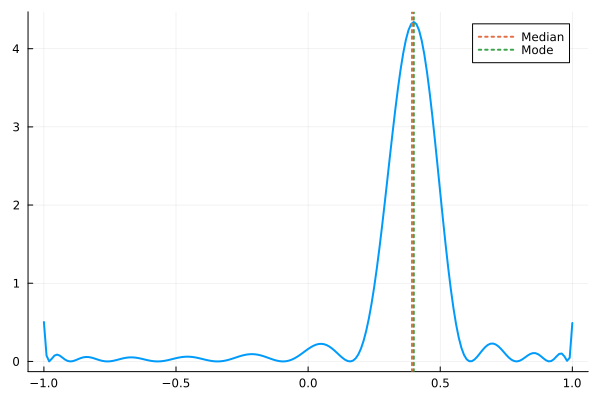

In [366]:
plot(xvals, ps, label="", lw=2)
vline!([med], label="Median", lw=2, ls=:dot)
vline!([mode_val], label="Mode", lw=2, ls=:dot)

# Uncertainty Quantification

### Weighted Median Absolute Deviation (WMAD)

In [370]:
wmad = median(abs.(xvals .- med), pweights(ps))

0.06245052471275155

In [336]:
med + wmad

0.5706052655150325

In [309]:
med - wmad

0.5002184039185612

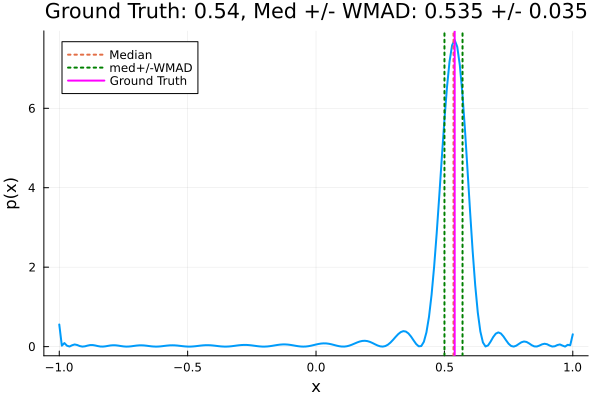

In [310]:
plot(xvals, ps, label="", lw=2, xlabel="x", ylabel="p(x)",
    title="Ground Truth: 0.54, Med +/- WMAD: $(round(med; digits=3)) +/- $(round(wmad; digits=3))")
vline!([med], label="Median", lw=2, ls=:dot)
vline!([med+wmad], c=:green, label="med+/-WMAD", lw=2, ls=:dot)
vline!([med-wmad], c=:green, label="", lw=2, ls=:dot)
vline!([0.54], c=:magenta, label="Ground Truth", lw=2)